# Scene Graph Prediction with Limited Labels

## 0. Overview

Scene Graph datasets like VisualGenome are rich representations of visual relationships between objects in images.
These data sets are very useful for downstream tasks, including captioning, visual question answering, and image generation.

<img width=50% src="http://visualgenome.org/static/images/front-page/interconnected_images.png">

However, scene graph datasets often contain a long tail of relationships with limited labels — often the result of expensive and error-prone manual annotation processes.

<img width=80% src="figs/sparsity.png">

In this demonstration, we use the original [VisualGenome](http://visualgenome.org/) dataset and sample `n=10` labels per predicate to simulate the limited label setting.

### Setup

First, we set up our notebook's logging and random seeds for reproducibility of this demonstration.

In [1]:
%load_ext autoreload
%autoreload 2

from typing import List

import json
import numpy as np
import random
import warnings

warnings.filterwarnings(action="ignore")

SEED = 123
random.seed(SEED)
np.random.seed(SEED)

## 1. Dataset Creation

We'll load in the existing [VisualGenome](visualgenome.org) dataset and pre-defined data splits.

To download this dataset, please run `./scripts/get_visualgenome.sh` from the root directory.

In [2]:
splits = np.load("data/VisualGenome/split.npy")
valid = np.load("data/VisualGenome/valid.npy")
annotations = json.load(open("data/VisualGenome/relationships.json"))

#### How many relationships are in each of our data splits?

In [3]:
# Filter corrupted images
valid_annotations = [annotations[i] for i in list(valid)]

# Split data
train = [valid_annotations[i] for i in list(np.where(splits == 0)[0])]
val = [valid_annotations[i] for i in list(np.where(splits == 1)[0])]
test = [valid_annotations[i] for i in list(np.where(splits == 2)[0])]

print("Total train images: ", len(train))
print("Total val images: ", len(val))
print("Total test images: ", len(test))

Total train images:  75651
Total val images:  10807
Total test images:  21615


### Identify relationship predicates
We'll use a set of predicates that capture rich, semantic meanings between objects in the image.

_NOTE: We choose a set of non-overlapping predicates to pose our multi-classification problem._

In [4]:
pred_list_fn = "pred_list.txt"
with open(pred_list_fn, "r") as f:
    predicates = sorted([x.strip() for x in f.readlines()])

predicates

['carrying',
 'covered in',
 'covering',
 'eating',
 'flying in',
 'growing on',
 'hanging from',
 'lying on',
 'mounted on',
 'painted on',
 'parked on',
 'playing',
 'riding',
 'says',
 'sitting on',
 'standing on',
 'using',
 'walking in',
 'walking on',
 'watching']

### Filtering the dataset

#### Filter relationships by the vocabulary of available objects

We'll load a vocabulary of `all_objects` that we'd like to include.

In [5]:
from utils.synonyms import SimilarCategories

object_list = [x.strip() for x in open("data/VisualGenome/object_list.txt", "r")]

Then, we extract object synonyms, so we can map similar words during feature extraction.

In [6]:
synonyms = SimilarCategories()
all_objects = set(object_list + synonyms.get_similar_objects(object_list))

Next, we filter the original dataset based on whether the relationships correspond to this list of objects.

In [7]:
from utils.visual_genome import filter_relationships
from utils.visual_genome import get_vg_obj_name


object_filter = lambda r: (
    get_vg_obj_name(r["subject"]) in all_objects
    and get_vg_obj_name(r["object"]) in all_objects
)
filter_relationships(annotations, object_filter, inplace=True)

100%|██████████| 108077/108077 [00:01<00:00, 74612.25it/s]


#### Filter relationships by predicates
We filter each split based on the available predicates.

In [8]:
%%time

predicate_filter = lambda r: r["predicate"].lower() in predicates
filtered_train = filter_relationships(train, predicate_filter)
filtered_val = filter_relationships(val, predicate_filter)
filtered_test = filter_relationships(test, predicate_filter)

100%|██████████| 21615/21615 [00:00<00:00, 142406.59it/s]

CPU times: user 18.9 s, sys: 155 ms, total: 19 s
Wall time: 19 s


#### Identify test splits for baselines/evaluations

The following filtered datasets can now uncommented to be used for experimental baselines and evaluation.

* In this notebook, we primarily use `EVAL_VALID` to measure the performance of our generated labels. 
* `ORACLE_TRAIN` includes _all_ training labels; it can be used to serve as an "upper bound" for downstream scene graph training, in the setting where (expensive!) annotator labels are available.
* `EVAL_TEST` can be used to evaluate downstream scene graph model performance.

In [9]:
# Used to validate performance of our training labels, hyperparameters, etc.
EVAL_VALID = filtered_val

# Includes ALL labels
# ORACLE_TRAIN = filtered_train

# Used to evaluate the downstream scene graph model performance
# EVAL_TEST = filtered_test

In the original dataset, we see that each relationship contains on average, ~1000 training labels (with high variance!).

In [10]:
from utils.visual_genome import count_relationships

train_counts = count_relationships(filtered_train)
train_counts

{'parked on': 744,
 'sitting on': 4211,
 'lying on': 319,
 'walking on': 1727,
 'carrying': 1855,
 'says': 81,
 'riding': 3819,
 'walking in': 285,
 'mounted on': 422,
 'covered in': 565,
 'standing on': 2031,
 'hanging from': 537,
 'using': 577,
 'eating': 713,
 'watching': 863,
 'covering': 549,
 'growing on': 438,
 'painted on': 229,
 'playing': 73,
 'flying in': 7,
 '_TOTAL': 20045}

### Drop ground truth labels for limited labels (`n=10`)

For the purposes of these experiments, we simulate the limited label setting by dropping ground truth labels for our the given predicates — for each predicate, we sample a maximum of $n$ labeled examples and treat all other relationships as `UNLABELED`.

In [11]:
from utils.visual_genome import sample_relationships

LIMITED_LABEL_TRAIN = sample_relationships(filtered_train, train_counts, n_per_pred=10)
count_relationships(LIMITED_LABEL_TRAIN)

{'UNLABELED': 19848,
 'says': 10,
 'parked on': 10,
 'eating': 10,
 'mounted on': 10,
 'walking on': 10,
 'covering': 10,
 'painted on': 10,
 'hanging from': 10,
 'walking in': 10,
 'lying on': 10,
 'carrying': 10,
 'using': 10,
 'standing on': 10,
 'watching': 10,
 'playing': 10,
 'covered in': 10,
 'sitting on': 10,
 'riding': 10,
 'growing on': 10,
 'flying in': 7,
 '_TOTAL': 20045}

### Visualize our dataset
We use a simple utility function to visualize random relationships from the dataset.

helmet <UNLABELED> motorcycle


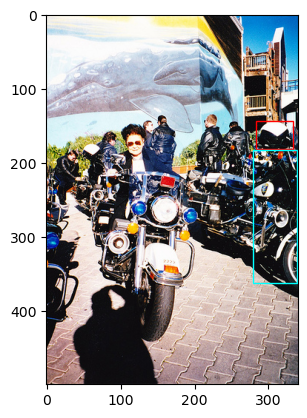

woman <UNLABELED> bag


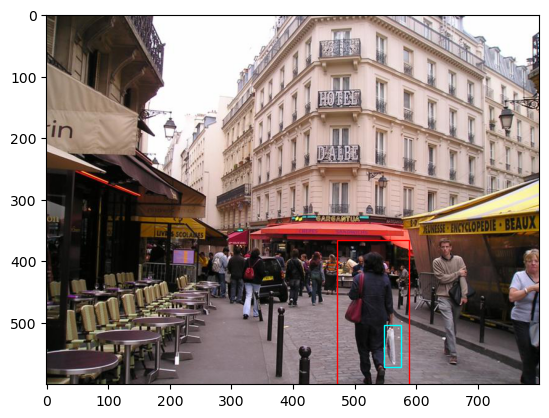

men <UNLABELED> bench


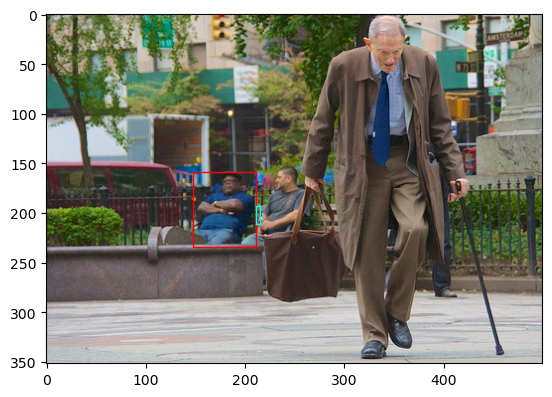

In [12]:
from utils.visualization import view_n_image_rels

view_n_image_rels(LIMITED_LABEL_TRAIN, n=3)

## 2. Extract _image-agnostic_ features
In this section, we'll extract _image-agnostic features_ based on the subject/object bounding boxes of each relationship.
We note that these features are **very cheap to extract**.
Using available bounding box features (or those generated from an off-the-shelf detector), we can alleviate the costs of hand-labeled data!

You can read more about these features in Section 3.3 of our [paper](https://arxiv.org/abs/1904.11622).

### Categorical features
These features represent the categorical label of each bounding box, which will be constructed as one-hot encodings for each bounding box.

$$
y_i = \begin{bmatrix}
\cdots & 0 & 0 & 0 & 1 & 0 & 0 & \cdots\\
\end{bmatrix}
$$

### Spatial features
Our spatial features are computing over bounding box properties directly.
Intuitively, they represent the **relative spatial positions, sizes, and aspect ratios between, subject and object bounding boxes**.

Formally, we denote the subject and object bounding boxes, $b = [x, y, w, h]$, $b' = [x', y', w', h']$, respectively, where $x$ is the left-most x-coordinate, $y$ is the top y-coordinate, $w$ is the width of the box, and $h$ is the height of the box.

We then extract the following features:


$$ \dfrac{x-x^\prime}{w}, \dfrac{y-y^\prime}{h}, \dfrac{(y+h)-(y^\prime+h^\prime)}{h}, \dfrac{(x+w)-(x^\prime+w^\prime)}{w},\dfrac{h^\prime}{h}, \dfrac{w^\prime}{w}, \dfrac{w^\prime h^\prime}{wh}, \dfrac{w^\prime + h^\prime}{w+h} $$

<hr>

First, we'll generate the vocabulary of possible object categories.

In [13]:
from utils.visual_genome import extract_obj_categories

object_synonyms = {}
for o in object_list:
    object_synonyms[o] = set(synonyms.get_similar_objects([o]) + [o])

obj_categories = extract_obj_categories(annotations, predicates, object_synonyms)
print("Here are the list of %d objects we have left" % len(obj_categories))
print(obj_categories)

Here are the list of 149 objects we have left
['airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike', 'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building', 'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup', 'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence', 'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy', 'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean', 'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men', 'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw', 'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post', 'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', '

Then, we'll extract our image-agnostic features from `LIMITED_LABEL_TRAIN`.

In [14]:
from utils.primitives import get_primitive_features

train_examples = get_primitive_features(
    LIMITED_LABEL_TRAIN, obj_categories, object_synonyms
)

100%|██████████| 75651/75651 [00:00<00:00, 230961.05it/s]


We view a set of image-agnostic features to confirm that these represent simple featurizations of bounding box pairs.

In [15]:
ex = random.choice(train_examples)
ex.spatial, ex.categorical

(array([ 1.66527197, -1.61924686, -0.34714004,  0.15384615,  4.28451883,
         0.49901381,  2.13803405]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

### Extract limited labels

We extract the associated set of `limited_labels` with the `get_labels` utility.

In [16]:
from utils.visual_genome import get_labels

limited_labels = get_labels(LIMITED_LABEL_TRAIN, predicates)

100%|██████████| 75651/75651 [00:00<00:00, 1170951.59it/s]


For this multiclass, semi-supervised problem, the set of limited labels is `[num_relationships, num_predicates]` matrix.

In [17]:
limited_labels.shape

(20045, 20)

Each row is a one-hot vector indicating the corresponding predicate label for this example. Label space:
* `-1`: Unknown
* `0`: Negative
* `1`: Positive

In [18]:
np.unique(limited_labels)

array([-1.,  0.,  1.])

Let's confirm how many labeled vs. unlabeled examples we have in this setting.

In [19]:
unlabeled_mask = np.sum(limited_labels, axis=1) == len(predicates) * -1
labeled_mask = np.logical_not(unlabeled_mask)
assert np.sum(labeled_mask) + np.sum(unlabeled_mask) == len(limited_labels)

In [20]:
print("Num labeled data points:", np.sum(labeled_mask))
print("Num unlabeled data points:", np.sum(unlabeled_mask))

Num labeled data points: 197
Num unlabeled data points: 19848


## 3. Generate _heuristics_ to noisily label visual relationships

Compute masks over the image-agnostic features for the small labeled set vs. the large set of unlabeled features.

Extract multiclass labels using the computed masks.

In [21]:
multiclass_limited_labels = np.where(limited_labels[labeled_mask, :] == 1.0)[1]

Now, we define several helper functions to learn heuristics the limited labels and perform inference on the unlabeled set.

In [22]:
from sklearn.tree import DecisionTreeClassifier

# PARAM: Threshold for rounding the heuristic outputs
THRESH = 0.3


def fit_heuristic(X_train, Y_train, min_samples_split):
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train, Y_train)
    return dt


def prob_to_label(prob_labels, thresh):
    # We default all labels to abstains = -1, by Snorkel convention
    rounded_labels = np.ones(prob_labels.shape[0]) * -1
    for i in range(rounded_labels.shape[0]):
        if np.max(prob_labels[i, :]) >= thresh:
            # Other classes are labeled as the argmax of estimated probabilities
            rounded_labels[i] = np.argmax(prob_labels[i, :])
    return rounded_labels

Fit the shallow heuristics over the limited labels, which can be treated as _noisy labelers_.
Use these heuristics to vote on the unlabeled set of relationships.

In [23]:
def examples_to_feat_matrix(examples: List[any], feature: str):
    feature_matrix = []
    for x in examples:
        feature_matrix.append(getattr(x, feature))

    feature_matrix = np.array(feature_matrix)
    return feature_matrix

In [24]:
img_agn_features = {
    "spatial": examples_to_feat_matrix(train_examples, feature="spatial"),
    "categorical": examples_to_feat_matrix(train_examples, feature="categorical")
}

* We define shallow heuristics (as shallow `DecisionTreeClassifier`s with the `min_samples_split` param).
* We fit each heuristic to both the spatial + categorical features.
* We treat each heuristic as a noisy _labeling function_ — they're not always correct, but they can be used to _programatically label_ a unlabeled data, cheaply! **This minimizes many of the expensive annotator costs that motivate our problem!**
    * To do this, we build on the building on the [Snorkel](snorkel.org) weak supervision framework.

In [25]:
from collections import defaultdict
from snorkel.labeling import labeling_function

# PARAM: Number of samples to look at in our decision trees
MIN_SAMPLES_SPLITS = [2, 4, 8, 16, 32, 64, 128]


lfs = []
heuristics = defaultdict(list)
for idx, ms in enumerate(MIN_SAMPLES_SPLITS):
    for feat_key, feat in img_agn_features.items():
        heuristic = fit_heuristic(feat[labeled_mask], multiclass_limited_labels, ms)

        @labeling_function(
            name=f"heuristic_ms:{ms}_feat:{feat_key}", 
            resources=dict(feat_key=feat_key, heuristic=heuristic, thresh=THRESH)
        )
        def lf(x, feat_key, heuristic, thresh):
            feat = getattr(x, feat_key)

            # Construct [1, feat_dim] np.array
            feat = np.expand_dims(feat, axis=0)

            probs = heuristic.predict_proba(feat)
            return prob_to_label(probs, thresh=thresh).squeeze()
        
        lfs.append(lf)


Next, we apply these noisy heuristics to the entire training dataset. 
The result is an `[num_examples, num_heuristics]` label matrix, `L_train`.

In [26]:
from snorkel.labeling import LFApplier

applier = LFApplier(lfs)
L_train = applier.apply(train_examples)

20045it [00:17, 1177.27it/s]


## 4. Combine heuristic outputs using generative model

We'd like to _combine and denoise_ our heuristic outputs so they can be used to train a downstream scene graph model.

Here, we fit the `LabelModel`, which is the generative model responsible for combining the heuristic outputs.

As a prior for the `LabelModel`, we compute the class balance of relationships using our validation set.

In [27]:
# Compute class_balance over val set
val_counts = count_relationships(filtered_val)
class_balance = np.array(
    [val_counts[k] / val_counts["_TOTAL"] for k in sorted(predicates)]
)

We learn model the accuracies of our noisy heuristics as a generative model in the [Snorkel](snorkel.org) framework.

In [28]:
from snorkel.labeling.model.label_model import LabelModel
# PARAM: Number of epochs to train the Generative Model
N_EPOCHS = 60


label_model = LabelModel(cardinality=20, verbose=True)
label_model.fit(L_train, class_balance=class_balance, seed=SEED, lr=0.01, l2=0.01, log_freq=10, n_epochs=N_EPOCHS)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/60 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=1.899]
INFO:root:[10 epochs]: TRAIN:[loss=1.663]
INFO:root:[20 epochs]: TRAIN:[loss=1.244]
INFO:root:[30 epochs]: TRAIN:[loss=0.934]
INFO:root:[40 epochs]: TRAIN:[loss=0.806]
INFO:root:[50 epochs]: TRAIN:[loss=0.728]
100%|██████████| 60/60 [00:00<00:00, 579.36epoch/s]
INFO:root:Finished Training


After fitting the `LabelModel`, we can perform inference to predict the "weak" labels for each predicate, producing a `[num_examples, num_predicates]` matrix of predictions.

In [29]:
weak_labels = label_model.predict_proba(L_train)
weak_labels.shape

(20045, 20)

### Validation
As a sanity check, we'd like to know: how do our generated labels perform on the validation set?

To start, we'll compute the same primitive features over the examples in `EVAL_VALID`.

In [30]:
valid_examples = get_primitive_features(
    EVAL_VALID, obj_categories, object_synonyms
)

L_valid = applier.apply(valid_examples)

100%|██████████| 10807/10807 [00:00<00:00, 197009.91it/s]
2698it [00:02, 1143.85it/s]


Then, we'll extract the ground truth labels for this data split.

In [31]:
valid_labels = get_labels(EVAL_VALID, predicates)
multiclass_labels_valid = np.where(valid_labels == 1.0)[1]
multiclass_labels_valid.shape

100%|██████████| 10807/10807 [00:00<00:00, 1266884.02it/s]


(2698,)

For a 20-way classification problem (where random chance is $\frac{1}{20} = 0.05$), our `label_model` produces reasonable labels!

In [32]:
label_model.score(L_valid, multiclass_labels_valid)

{'accuracy': 0.505930318754633}

## 5. Train your favorite scene graph prediction model!

We can then leverage the probabilistic labels generated over the training dataset, `weak_labels`, to bootstrap training of any state-of-the-art scene graph model!

We note that `weak_labels` only take advantage of simple bounding box/categorical features for individual bounding box pairs. 
We expect that using a deeper neural network can further leverage deep features / complex architectures, allowing the model to generalize to additional data distributions!